In [60]:
import pandas as pd #type:ignore
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold #type:ignore
from sklearn.tree import DecisionTreeClassifier #type:ignore
from sklearn.naive_bayes import GaussianNB #type:ignore
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score  # type: ignore #type:ignore
from sklearn.preprocessing import StandardScaler #type:ignore
from imblearn.over_sampling import SMOTE, RandomOverSampler #type:ignore
import matplotlib.pyplot as plt #type:ignore
import seaborn as sns #type:ignore
from sklearn.ensemble import RandomForestClassifier  # type: ignore

## 1. **Reading Data**

In [61]:
# Reading haberman.csv
data = pd.read_csv("haberman.csv")
print(data.head())

   age  operation_year  nbr_axillary_nodes  survival_status
0   30              64                   1                1
1   30              62                   3                1
2   30              65                   0                1
3   31              59                   2                1
4   31              65                   4                1


---
## 2. **Analysis and Visualization**

In [62]:
# a. Number of rows and columns
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

Number of rows: 306
Number of columns: 4


Data types:
age                   int64
operation_year        int64
nbr_axillary_nodes    int64
survival_status       int64

survival_status
1    225
2     81


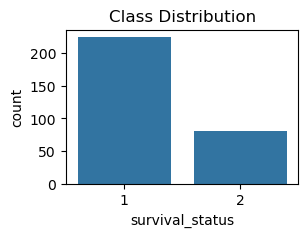

In [63]:
# b. Data types 
print("Data types:\n" + data.dtypes.to_string()) # Data types

# Class distribution
print("\n" + data['survival_status'].value_counts().to_string())  
plt.figure(figsize=(3,2)) # Class distribution plot
sns.countplot(x='survival_status', data=data,)
plt.title("Class Distribution")
plt.show()

---
## 3 . **Preprocessing**

In [64]:
# a. Handling Missing Values
print("Missing values:\n"+data.isnull().sum().to_string())

data['age'] = data['age'].fillna(data['age'].mean()) # missing -> mean
data = data.dropna(subset=['operation_year']) # missing -> drop
data['nbr_axillary_nodes'] = data['nbr_axillary_nodes'].fillna(data['nbr_axillary_nodes'].median()) # missing -> median
data = data.dropna(subset=['survival_status']) # missing -> drop

Missing values:
age                   0
operation_year        0
nbr_axillary_nodes    0
survival_status       0


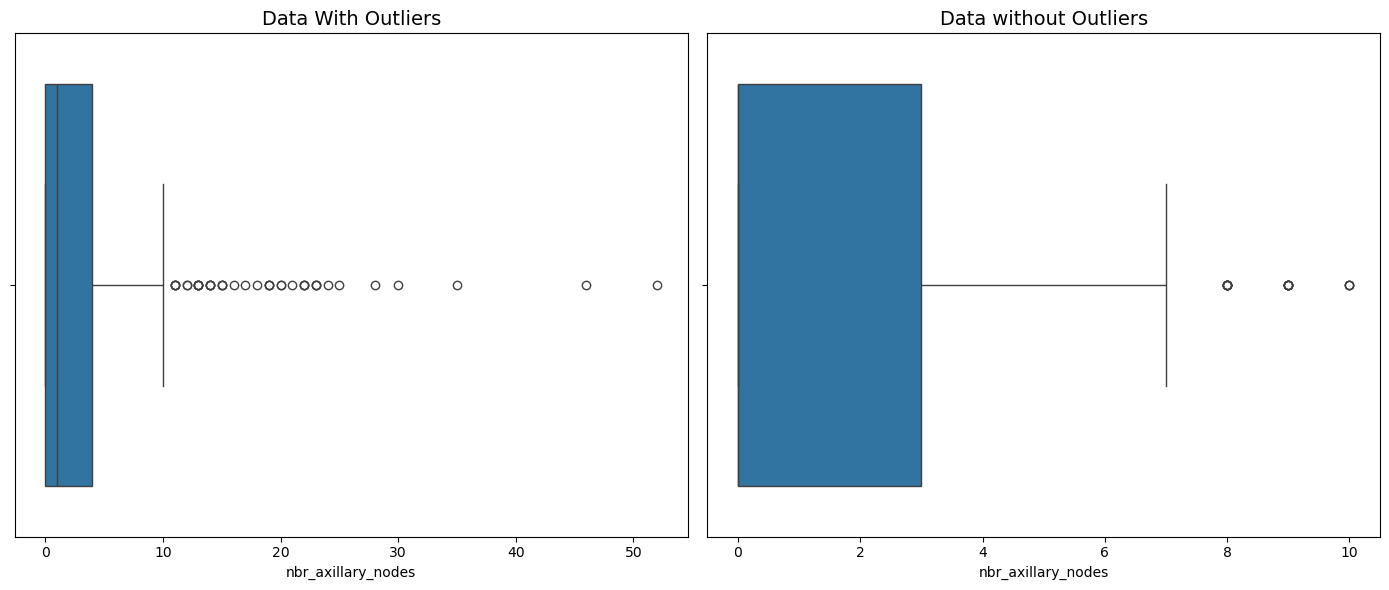

In [65]:
# b. Handling outliers for "nbr_axillary_nodes"
Q1 = data['nbr_axillary_nodes'].quantile(0.25)
Q3 = data['nbr_axillary_nodes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

original_data = data.copy()
data = data[(data['nbr_axillary_nodes'] >= lower_bound) & (data['nbr_axillary_nodes'] <= upper_bound)]

# Create a figure with two subplots side by side
plt.figure(figsize=(14, 6))

# First subplot: Data without outliers
plt.subplot(1, 2, 1)
sns.boxplot(x=original_data['nbr_axillary_nodes'])
plt.title("Data With Outliers", fontsize=14)

# Second subplot: Original data with outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=data['nbr_axillary_nodes'])
plt.title("Data without Outliers", fontsize=14)

plt.tight_layout()
plt.show()



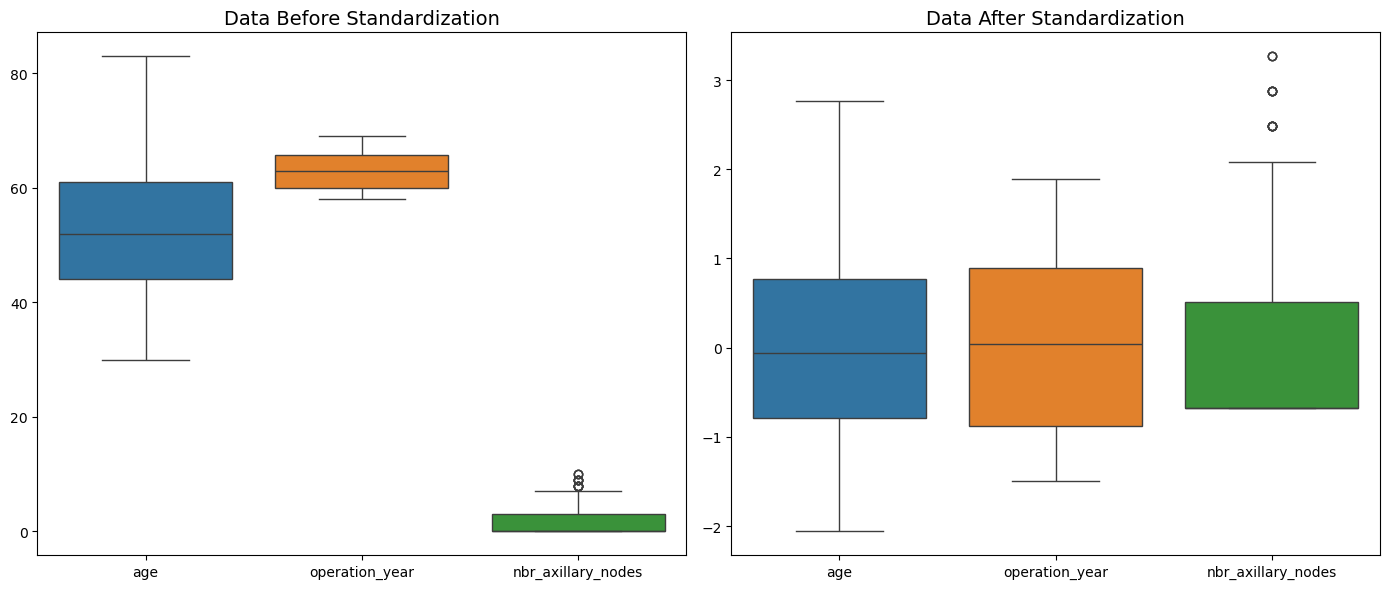

In [66]:
# c. Standarization 
data_before = data.copy()

scaler = StandardScaler()
data[['age', 'operation_year', 'nbr_axillary_nodes']] = scaler.fit_transform(data[['age', 'operation_year', 'nbr_axillary_nodes']])

# Visualizing results 
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=data_before[['age', 'operation_year', 'nbr_axillary_nodes']])
plt.title("Data Before Standardization", fontsize=14)

plt.subplot(1, 2, 2)
sns.boxplot(data=data[['age', 'operation_year', 'nbr_axillary_nodes']])
plt.title("Data After Standardization", fontsize=14)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

---
## 4. **cross-validation**

In [67]:
# Prepare the features and target
X = data[['age', 'operation_year', 'nbr_axillary_nodes']]
y = data['survival_status']
dt_model = DecisionTreeClassifier(random_state=69)
nb_model = GaussianNB()

# Apply K-Fold Cross-Validation with random_state set to 69
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=69)  # 3 splits

# Perform cross-validation
dt_scores = cross_val_score(dt_model, X, y, cv=kfold)
nb_scores = cross_val_score(nb_model, X, y, cv=kfold)

print(f"DT Scores: {dt_scores}")
print(f"Mean: {dt_scores.mean():.2f}")

print(f"\nNB Scores: {nb_scores}")
print(f"Mean: {nb_scores.mean():.2f}")

DT Scores: [0.70786517 0.6741573  0.70454545]
Mean: 0.70

NB Scores: [0.76404494 0.74157303 0.77272727]
Mean: 0.76


---
## 5. **Classification**

In [68]:
# Step 4: Split data into training and testing sets (80% train, 20% test)
X = data[['age', 'operation_year', 'nbr_axillary_nodes']]
y = data['survival_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Decision Tree 
dt_model = DecisionTreeClassifier(random_state=69)      # Initialize model 
dt_model.fit(X_train, y_train)                          # Train model
y_pred_dt = dt_model.predict(X_test)                    
dt_accuracy = accuracy_score(y_test, y_pred_dt)         # Evaluate model
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted')
dt_precision = precision_score(y_test, y_pred_dt, average='weighted')
dt_recall = recall_score(y_test, y_pred_dt, average='weighted')

# NB 
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb, average='weighted')
nb_precision = precision_score(y_test, y_pred_nb, average='weighted')
nb_recall = recall_score(y_test, y_pred_nb, average='weighted')


# Save the results to a CSV file
results = {
    'Model': ['Decision Tree', 'Naive Bayes'],
    'Accuracy': [dt_accuracy, nb_accuracy],
    'F1-Score': [dt_f1, nb_f1]
}

results_df = pd.DataFrame(results)
print(results_df)

# Save to CSV
results_df.to_csv('classification_results.csv', index=False)

           Model  Accuracy  F1-Score
0  Decision Tree  0.611111  0.587106
1    Naive Bayes  0.703704  0.635017


---
## 6. **Handling Imbalanced Classes**

In [69]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Using SMOTE to oversample the minority class
smote = SMOTE(random_state=69)
X_train_smote, y_train_smote = smote.fit_resample(X, y)


# Train the Decision Tree and Naive Bayes models with SMOTE data
dt_smote = DecisionTreeClassifier(random_state=69)
nb_smote = GaussianNB()
dt_smote.fit(X_train_smote, y_train_smote)
nb_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_dt = dt_smote.predict(X_test)
y_pred_nb = nb_smote.predict(X_test)

# Evaluate the models
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Evaluate with SMOTE data
dt_smote_accuracy, dt_smote_precision, dt_smote_recall, dt_smote_f1= evaluate_model(y_test, y_pred_dt)
nb_smote_accuracy, nb_smote_precision, nb_smote_recall, nb_smote_f1= evaluate_model(y_test, y_pred_nb)

# Print the results
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Naive Bayes', 'Decision Tree (SMOTE)', 'Naive Bayes (SMOTE)'],
    'Accuracy': [dt_accuracy, nb_accuracy, dt_smote_accuracy, nb_smote_accuracy],
    'F1 Score': [dt_f1, nb_f1, dt_smote_f1, nb_smote_f1],
    'Precision': [dt_precision,nb_precision, dt_smote_precision, nb_smote_precision],
    'Recall': [dt_recall, nb_recall, dt_smote_recall, nb_smote_recall]
})
print(results)


                   Model  Accuracy  F1 Score  Precision    Recall
0          Decision Tree  0.611111  0.587106   0.571764  0.611111
1            Naive Bayes  0.703704  0.635017   0.654815  0.703704
2  Decision Tree (SMOTE)  0.962963  0.961710   0.964646  0.962963
3    Naive Bayes (SMOTE)  0.740741  0.740741   0.740741  0.740741


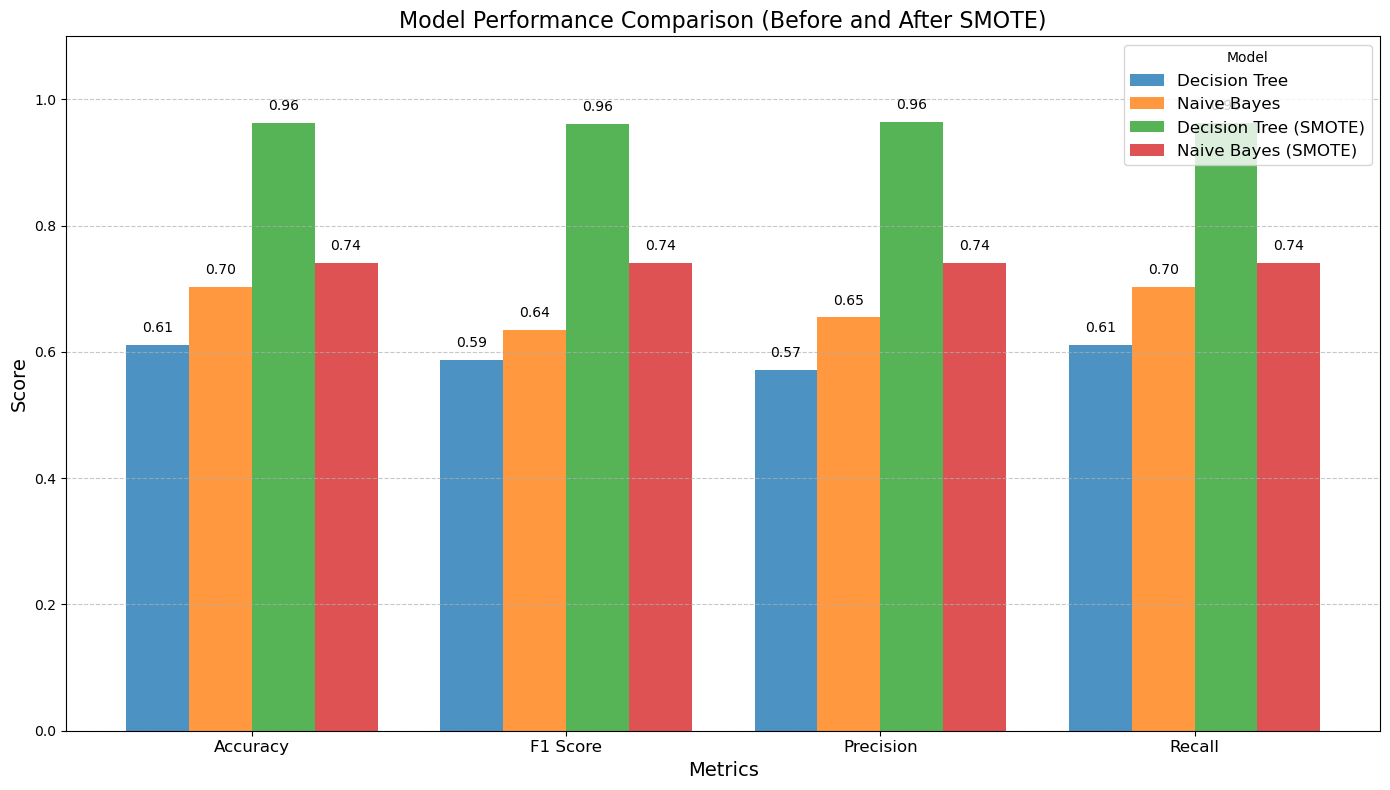

In [70]:
# Set index to model names for easy visualization
results.set_index('Model', inplace=True)

# Prepare data for grouped bar plot
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
models = ['Decision Tree', 'Naive Bayes', 'Decision Tree (SMOTE)', 'Naive Bayes (SMOTE)']

# Create a DataFrame with metrics for easier visualization
metric_data = results.T  # Transpose for grouping by metrics
metric_data.columns = models

# Plot grouped bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.2
x = range(len(metrics))

# Plot bars for each model
for i, model in enumerate(models):
    plt.bar(
        [pos + i * bar_width for pos in x],
        metric_data[model],
        width=bar_width,
        label=model,
        alpha=0.8
    )

# Add labels, title, and legend
plt.title("Model Performance Comparison (Before and After SMOTE)", fontsize=16)
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks([pos + 1.5 * bar_width for pos in x], metrics, fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title="Model", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations
for i, model in enumerate(models):
    for j, value in enumerate(metric_data[model]):
        plt.text(
            j + i * bar_width,
            value + 0.02,
            f"{value:.2f}",
            ha='center',
            fontsize=10
        )

# Show the plot
plt.tight_layout()
plt.show()


In [71]:
# Handling Imbalanced Classes with SMOTE


# Decision Tree with SMOTE
dt_smote = DecisionTreeClassifier(random_state=42)
dt_smote.fit(X_resampled, y_resampled)
dt_smote_preds = dt_smote.predict(X_test)
dt_smote_accuracy = accuracy_score(y_test, dt_smote_preds)
dt_smote_f1 = f1_score(y_test, dt_smote_preds, average='weighted')

# Naive Bayes with SMOTE
nb_smote = GaussianNB()
nb_smote.fit(X_resampled, y_resampled)
nb_smote_preds = nb_smote.predict(X_test)
nb_smote_accuracy = accuracy_score(y_test, nb_smote_preds)
nb_smote_f1 = f1_score(y_test, nb_smote_preds, average='weighted')


# Save results to CSV
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Naive Bayes', 'Decision Tree (SMOTE)', 'Naive Bayes (SMOTE)'],
    'Accuracy': [dt_accuracy, nb_accuracy, dt_smote_accuracy, nb_smote_accuracy],
    'F1 Score': [dt_f1, nb_f1, dt_smote_f1, nb_smote_f1]
})
print(results)

                   Model  Accuracy  F1 Score
0          Decision Tree  0.611111  0.587106
1            Naive Bayes  0.703704  0.635017
2  Decision Tree (SMOTE)  0.962963  0.961710
3    Naive Bayes (SMOTE)  0.777778  0.788095
